The purpose of this notebook is to show how to train adapter
models to transform query embeddings based on user feedback.

In this notebook, both queries and feedbacks are generated with an LLM. So, this is for demonstration purposes. You may obtain better fitted adapter model with actual user feedback.

You will train a simple adapter model, transform model genenerated queires and see if you can get same, worse or better documents retrieved with the adapted queries.

The leanrned adapter matrix is influenced by the distribution of +ve and -ve labels. So, there is a tendency to transform to one rigon on the embedding space if we have more +ve or -ve labels.

This notebook is adapted from:
https://learn.deeplearning.ai/advanced-retrieval-for-ai/lesson/6/embedding-adaptors

Notebook is created on SageMaker Studio Lab (free)

In [ ]:
%pip install --upgrade --quiet pypdf python-dotenv umap-learn chromadb \
    langchain huggingface_hub sentence-transformers

In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from huggingface_hub import login
_ = load_dotenv(find_dotenv()) # read local .env file
hugging_face_access_token = os.environ['HUGGINGFACEHUB_API_TOKEN']
login(hugging_face_access_token)

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /home/studio-lab-user/.cache/huggingface/token
Login successful


In [2]:
from embedding_utils import load_chroma, word_wrap
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf',
    collection_name='microsoft_annual_report_2022',
    embedding_function=embedding_function)

chroma_collection.count()

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


349

In [25]:
import numpy as np
from tqdm import tqdm
def project_embeddings(embeddings, umap_transform):
    umap_embeddings = np.empty((len(embeddings),2))
    for i, embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings

In [26]:
# https://pypi.org/project/umap-learn/
import umap
embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
100%|██████████| 349/349 [06:33<00:00,  1.13s/it]


In [4]:
from dataclasses import dataclass

@dataclass
class PlotLayer:
    embedding: list
    size: int = None
    color: str = None
    facecolor: str = None
    edgecolor: str = None
    marker: str = None
    label: str = None

%matplotlib inline
import matplotlib.pyplot as plt

def plot_projections(title, PlotLayers: list[PlotLayer], legend: list[str] = []) -> None:
    plt.figure()
    for PlotLayer in PlotLayers:
        plt.scatter(PlotLayer.embedding[:, 0], PlotLayer.embedding[:, 1],
            s=PlotLayer.size, marker=PlotLayer.marker, color=PlotLayer.color,
            facecolor = PlotLayer.facecolor, edgecolor=PlotLayer.edgecolor)

    plt.gca().set_aspect('equal', 'datalim')
    plt.title(title)
    plt.axis('off')
    if len(legend) > 0:
        plt.legend(legend)

In [5]:
import llm_utils
llm = llm_utils.HuggingFaceHub(
    repo_id="HuggingFaceH4/zephyr-7b-beta",
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 30,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

chat_model = llm_utils.ChatHuggingFace(llm=llm)

WARNING! repo_id is not default parameter.
                    repo_id was transferred to model_kwargs.
                    Please confirm that repo_id is what you intended.
WARNING! task is not default parameter.
                    task was transferred to model_kwargs.
                    Please confirm that task is what you intended.
WARNING! huggingfacehub_api_token is not default parameter.
                    huggingfacehub_api_token was transferred to model_kwargs.
                    Please confirm that huggingfacehub_api_token is what you intended.


In [6]:
from langchain.schema import HumanMessage, SystemMessage
from langchain.prompts import ChatPromptTemplate
def generate_queries(chat_model):

    system_message = """
        You are a helpful expert financial research assistant.\n
        You help users analyze financial statements to better
        understand companies. Suggest 10 to 15 short questions that
        are important to ask when analyzing an annual report.\n\n
        Do not output any compound questions
        (questions with multiple sentences or conjunctions).
        Output each question on a separate line divided by a newline.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content="Follow instructions when generating queries."

      ),
    ]

    response = chat_model.invoke(messages)
    response = response.content.split("\n")
    return response

Note: you probably need to sample or clean these queries, for example if too many were generated or empty spaces were included, etc. This depends on the LLM you are using.

In [7]:
generated_queries = generate_queries(chat_model=chat_model)
for query in generated_queries:
    print(query)

1. What is the company's revenue for the current year and how does it compare to the previous year?
2. What is the company's net income for the current year and how does it compare to the previous year?
3. What is the company's gross margin and has it changed significantly from the previous year?
4. What is the company's debt-to-equity ratio and has it increased or decreased over the past few years?
5. What is the company's return on equity (ROE) and how does it compare to industry averages?
6. What is the company's current ratio and has it remained stable over the past few years?
7. What is the company's inventory turnover ratio and has it improved or declined over the past few years?
8. What is the company's accounts receivable turnover ratio and has it improved or declined over the past few years?
9. What is the company's cash flow from operating activities and how does it compare to the previous year?
10. What are the company's major expenses and have they increased or decreased ov

In [8]:
results = chroma_collection.query(query_texts=generated_queries, n_results=10,
                                  include=['documents', 'embeddings'])
retrieved_documents = results['documents']
print(len(retrieved_documents) * len(retrieved_documents[0]))

retrieved_embeddings = results['embeddings']

# generated query embeddings
query_embeddings = embedding_function(generated_queries)
len(query_embeddings)

150


15

Create a prompt appropriate for the model you are using.

In [11]:
import json
from langchain_core.output_parsers import JsonOutputParser
def evaluate_results(query, statement, chat_model):

    system_message = """
        You are a helpful expert financial research assistant. \n
        You help users analyze financial statements
        to better understand companies.\n\n
        For the given query, evaluate whether the following satement is relevant.\n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question. \n
        Provide the binary score as a JSON with a single key 'score' and no premable or explaination.
    """

    messages = [
      SystemMessage(content=system_message),
      HumanMessage(
        content=f"Query: {query}, Statement: {statement}"

      ),
    ]

    response = chat_model.invoke(messages)
    response = response.content
    if len(response.strip()) > 0:
        answer = None
        try:
            response = JsonOutputParser(response)
            answer = response[score]
            if answer.lower() == 'yes':
                return 1
            return -1
        except:
            if 'yes' in response.lower():
                return 1
            return -1
    return 0


In [12]:
adapter_query_embeddings = [] # for query embeddings
adapter_doc_embeddings = [] # for result embeddings
adapter_labels = [] # for generated labels

In [13]:
# q and d are used as list indices
# query and document are texts that are evaluated
# label is the result of query and document evaluation

for q, query in enumerate(tqdm(generated_queries)):
    for d, document in enumerate(retrieved_documents[q]):
        if len(document.strip()) != 0:
            label = evaluate_results(query, document, chat_model)
            if label == 1 or label == -1:
                adapter_query_embeddings.append(query_embeddings[q])
                adapter_doc_embeddings.append(retrieved_embeddings[q][d])
                adapter_labels.append(label)

100%|██████████| 15/15 [20:39<00:00, 82.66s/it]


In [14]:
len(adapter_labels), len(adapter_query_embeddings), len(adapter_doc_embeddings)

(150, 150, 150)

In [15]:
p = sum([n for n in adapter_labels if n == 1])
n = sum([n for n in adapter_labels if n == -1])
print(f"positives = {p} and negatives = {n}")

positives = 53 and negatives = -97


As you can see, most of the labels are negative and the adapter model will make queries more negative. In user evaluated data set, there may be balanced lables and hence the model may not be biased.

In [16]:
import torch
from torch.utils.data import TensorDataset

adapter_query_embeddings = torch.Tensor(adapter_query_embeddings)
adapter_doc_embeddings = torch.Tensor(adapter_doc_embeddings)
adapter_labels = torch.Tensor(adapter_labels)
adapter_labels = adapter_labels.reshape(adapter_labels.shape[0],)

#check shapes match for TensorDataSet creation
print(adapter_query_embeddings.shape, adapter_doc_embeddings.shape, adapter_labels.shape)

dataset = TensorDataset(adapter_query_embeddings, adapter_doc_embeddings, adapter_labels)

torch.Size([150, 384]) torch.Size([150, 384]) torch.Size([150])


Create a simple adapter model.

In [17]:
class AdapterModel(torch.nn.Module):
    def __init__(self, adpater_matrix_shape):
        super().__init__()
        self.adapter_matrix = torch.nn.Parameter(
            torch.zeros(adpater_matrix_shape),
            requires_grad=True)

        # try different initializaiton methods
        torch.nn.init.xavier_uniform_(self.adapter_matrix)

    def forward(self, input):
        output = self.adapter_matrix @ input.t()
        return output.t()

In [18]:
def get_model():
    model = AdapterModel((384, 384))
    return model

In [19]:
model = get_model()
for p in model.parameters():
    print(p.shape)
    print(p)

torch.Size([384, 384])
Parameter containing:
tensor([[ 0.0367, -0.0279,  0.0635,  ...,  0.0040, -0.0163,  0.0437],
        [-0.0853,  0.0761, -0.0439,  ...,  0.0796,  0.0558, -0.0433],
        [ 0.0850, -0.0849,  0.0711,  ...,  0.0551,  0.0850,  0.0166],
        ...,
        [ 0.0123,  0.0515, -0.0754,  ..., -0.0263,  0.0258,  0.0345],
        [ 0.0039, -0.0844, -0.0841,  ..., -0.0413,  0.0633, -0.0422],
        [ 0.0218, -0.0719, -0.0507,  ...,  0.0485, -0.0748,  0.0320]],
       requires_grad=True)


In [20]:
model = get_model()
test_vectors = torch.ones([3, 384])
result = model(test_vectors)
result.shape

torch.Size([3, 384])

In [21]:
# define train function
def train(model, optimizer, loss_func, epochs=100):
    optimizer.zero_grad()
    for epoch in tqdm(range(epochs)):
        for query_embedding, document_embedding, label in dataset:
            updated_query_embedding = model(query_embedding)
            cosine_similarity = F.cosine_similarity(updated_query_embedding, document_embedding, dim=0)
            loss = loss_func(cosine_similarity, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    print("\n")
    print(f"loss = {loss.detach().numpy()}")


In [22]:
import torch.nn.functional as F
from torch import optim

model = get_model()

# create a loss function
def loss_function(cosine_similarity, label):
    return F.mse_loss(cosine_similarity, label)

# crete an optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)

#train
train(model=model, optimizer=optimizer, loss_func=loss_function)

100%|██████████| 100/100 [00:20<00:00,  4.81it/s]



loss = 0.3140372931957245


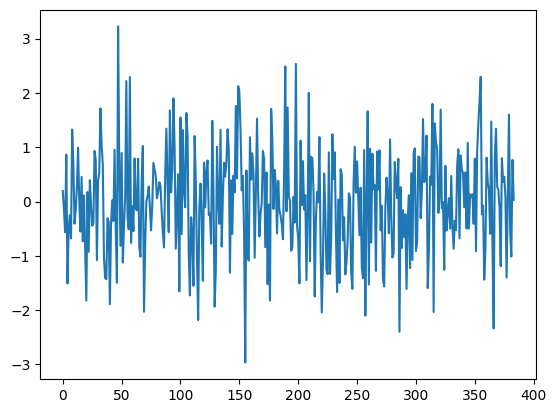

In [23]:
# The transformation of a unit vector by the lreaned adapter matrix.
# Some of the dimenstion are stretched in the positive and some
# in the opposite dimensions. Some are shrinked to 0

test_vector = torch.ones(384)

model.eval()
with torch.no_grad():
    scaled_vector = model(test_vector)

plt.plot(scaled_vector.numpy())
plt.show()

As we have anticipated, the model is shrinking dimensions. This is the result of too many negative labels in the model's evaluation of quries and retrieved documents. Because LLM results are non-deterministic, your experiment might result in different query transformations.

Transform query embedings using the trained adapter model

In [27]:
query_embeddings = embedding_function(generated_queries)

input_query_embeddings = torch.Tensor(query_embeddings)

with torch.no_grad():
    adapted_query_embeddings = model(input_query_embeddings).numpy()

projected_query_embeddings = project_embeddings(query_embeddings, umap_transform)
projected_adapted_query_embeddings = project_embeddings(adapted_query_embeddings, umap_transform)

100%|██████████| 15/15 [00:16<00:00,  1.13s/it]


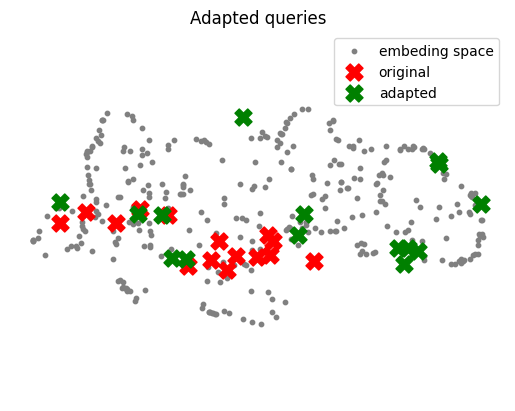

In [28]:
# Plot the projected query and retrieved documents in the embedding space
# Notice how queries are now appearing
layers = [PlotLayer(projected_dataset_embeddings, size=10, color='gray', label="embeding space"),
               PlotLayer(projected_query_embeddings, size=150, marker='X', color='r', label="original"),
               PlotLayer(projected_adapted_query_embeddings, size=150, marker='X', color='green', label="adapted" )]
plot_projections("Adapted queries", layers, ["embeding space", "original", "adapted"])

You can see that the adapter matrix shifted queries to certain parts of the embedding space.

In [29]:
label_index = 0

for i in range(len(query_embeddings)):
      print("label       orignial similarity   adapted similarity")
      print("-"*60)
      for j in range(len(retrieved_embeddings[i])):

          label = adapter_labels[label_index]

          old_query_embedding = torch.tensor(query_embeddings[i])
          adapted_query = torch.tensor(adapted_query_embeddings[i])

          sim0 = torch.cosine_similarity(old_query_embedding, adapted_query, dim=0).numpy()

          document_embedding = torch.tensor(np.array(retrieved_embeddings[i][j]))

          sim1 = torch.cosine_similarity(old_query_embedding, document_embedding, dim=0).numpy()
          sim2 = torch.cosine_similarity(adapted_query, document_embedding, dim=0).numpy()

          print(label, sim1, sim2)
        
          if label_index < len(adapter_labels)-1:

              label_index += 1

          print("-"*60)


label       orignial similarity   adapted similarity
------------------------------------------------------------
tensor(1.) 0.5577218516415642 0.4804841140500332
------------------------------------------------------------
tensor(1.) 0.5503861053367827 0.441958303779424
------------------------------------------------------------
tensor(1.) 0.5487728752864902 0.3581853202887992
------------------------------------------------------------
tensor(-1.) 0.5437011539095886 0.02299687779877394
------------------------------------------------------------
tensor(1.) 0.5283616657779667 0.4729351294865627
------------------------------------------------------------
tensor(-1.) 0.5135865218444909 -0.08505628690462425
------------------------------------------------------------
tensor(1.) 0.5126162215337573 0.4869760212055736
------------------------------------------------------------
tensor(1.) 0.5060168660053658 0.455412510665034
------------------------------------------------------------
ten

Some of the queries are made better and some worse. Play with it and see why.

In [30]:
index = 2
print(word_wrap(generated_queries[index]))
print("")
qe = query_embeddings[index]
results = chroma_collection.query(query_embeddings=qe, n_results=5,
                                  include=['documents', 'embeddings'])
docs = results["documents"]
for doc in docs:
    for d in doc:
        print(word_wrap(d))

3. What is the company's gross margin and has it changed significantly
from the previous year?

gross margin increased $ 19. 8 billion or 17 % driven by growth across
each of our segments. • gross margin percentage decreased slightly.
excluding the impact of the fiscal year 2021 change in accounting
estimate for the useful lives of our server and network equipment,
gross margin percentage increased 1 point driven by improvement in
productivity and business processes. • microsoft cloud gross margin
percentage decreased slightly to 70 %. excluding the impact of the
change in accounting estimate, microsoft cloud gross margin percentage
increased 3 points driven by improvement across our cloud services,
offset in part by sales mix shift to azure and other cloud services.
operating expenses increased $ 6. 3 billion or 14 % driven by
investments in cloud engineering, linkedin, gaming, and commercial
sales. key changes in operating expenses were : • research and
development expenses increased

In [31]:
print(word_wrap(generated_queries[index]))
print("")
aqe = adapted_query_embeddings[index].tolist()
results = chroma_collection.query(query_embeddings=aqe, n_results=5,
                                  include=['documents', 'embeddings'])
docs = results["documents"]
for doc in docs:
    for d in doc:
        print(word_wrap(d))

3. What is the company's gross margin and has it changed significantly
from the previous year?

• dynamics products and cloud services revenue increased 25 % driven by
dynamics 365 growth of 39 %. operating income increased $ 5. 3 billion
or 22 %. • gross margin increased $ 7. 3 billion or 17 % driven by
growth in office 365 commercial and linkedin. gross margin percentage
was relatively unchanged. excluding the impact of the change in
accounting estimate, gross margin percentage increased 2 points driven
by improvement across all cloud services. • operating expenses
increased $ 2. 0 billion or 11 % driven by investments in linkedin and
cloud engineering. gross margin and operating income both included an
unfavorable foreign currency impact of 2 %. intelligent cloud revenue
increased $ 15. 2 billion or 25 %. • server products and cloud services
revenue increased $ 14. 7 billion or 28 % driven by azure and other
cloud services. azure and other cloud services revenue grew 45 % driven
by 